<a href="https://colab.research.google.com/github/VishalGowthaman/Urban_Sound_Companion/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q pydub librosa resampy
!apt-get install -y ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
import os
import numpy as np
import pandas as pd
from pydub import AudioSegment
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [4]:
def convert_ogg_to_wav(ogg_file_path, wav_file_path):
    try:
        audio = AudioSegment.from_ogg(ogg_file_path)
        audio.export(wav_file_path, format="wav")
        print(f"Successfully converted {ogg_file_path} to {wav_file_path}")
    except Exception as e:
        print(f"Error converting {ogg_file_path}: {e}")

In [5]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        return np.concatenate((np.mean(mfccs, axis=1), np.mean(chroma, axis=1)))
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [6]:
base_directory = '/content/drive/My Drive/audio_dataset/audio_dataset'
ogg_directories = ['Baby_noise', 'Crying_Baby']
wav_directories = ['bird', 'Cat', 'Dog', 'Door_bell', 'Door_knock', 'Laughing_Baby', 'Silence_background', 'Vehicle']


In [7]:
data = []
labels = []

In [8]:
for ogg_directory in ogg_directories:
    ogg_path = os.path.join(base_directory, ogg_directory)
    for filename in os.listdir(ogg_path):
        if filename.endswith('.ogg'):
            ogg_file_path = os.path.join(ogg_path, filename)
            wav_file_path = os.path.join(ogg_path, filename.replace('.ogg', '.wav'))
            convert_ogg_to_wav(ogg_file_path, wav_file_path)
            features = extract_features(wav_file_path)
            if features is not None:
                data.append(features)
                labels.append(ogg_directory)

Successfully converted /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-100032-A.ogg to /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-100032-A.wav
Successfully converted /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-13571-A.ogg to /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-13571-A.wav
Successfully converted /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-110389-A.ogg to /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-110389-A.wav
Successfully converted /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-13572-A.ogg to /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-13572-A.wav
Successfully converted /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-21421-A.ogg to /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-21421-A.wav
Successfully converted /content/drive/My Drive/audio_dataset/audio_dataset/Baby_noise/1-22804-A.

In [9]:
for wav_directory in wav_directories:
    wav_path = os.path.join(base_directory, wav_directory)
    for filename in os.listdir(wav_path):
        if filename.endswith('.wav'):
            wav_file_path = os.path.join(wav_path, filename)
            features = extract_features(wav_file_path)
            if features is not None:
                data.append(features)
                labels.append(wav_directory)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [10]:
df = pd.DataFrame(data)
df['label'] = labels
df.to_csv('audio_features.csv', index=False)

In [11]:
X = np.array(data)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

In [15]:
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 24, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,634 (182.16 KB)

 Trainable params: 46,634 (182.16 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), epochs=50, batch_size=32, verbose=1)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2292 - loss: 2.1929 - val_accuracy: 0.4591 - val_loss: 1.7956
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4649 - loss: 1.7180 - val_accuracy: 0.5975 - val_loss: 1.5002
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5465 - loss: 1.4417 - val_accuracy: 0.6038 - val_loss: 1.3556
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5650 - loss: 1.3126 - val_accuracy: 0.6101 - val_loss: 1.2259
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6315 - loss: 1.1715 - val_accuracy: 0.6289 - val_loss: 1.1358
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6994 - loss: 1.0020 - val_accuracy: 0.6981 - val_loss: 1.0545
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7005 - loss: 0.9553 - val_accuracy: 0.6918 - val_loss: 1.0151
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7313 - loss: 0.8821 - val_accuracy: 0.7421 - val_loss

In [18]:
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8549 - loss: 0.7472 
Test Accuracy: 82.39%


In [19]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import load_model
from PIL import Image
import librosa
import matplotlib.pyplot as plt

In [20]:
image_folder_path = '/content/drive/My Drive/images'  # Folder where images are stored
category_image_map = {
    'Baby_noise': os.path.join(image_folder_path, 'baby_noise.jpg'),
    'Crying_Baby': os.path.join(image_folder_path, 'crying_baby.jpg'),
    'bird': os.path.join(image_folder_path, 'bird.jpg'),
    'Cat': os.path.join(image_folder_path, 'cat.jpg'),
    'Dog': os.path.join(image_folder_path, 'dog.jpg'),
    'Door_bell': os.path.join(image_folder_path, 'door_bell.jpg'),
    'Door_knock': os.path.join(image_folder_path, 'door_knock.jpg'),
    'Laughing_Baby': os.path.join(image_folder_path, 'laughing_baby.jpg'),
    'Silence_background': os.path.join(image_folder_path, 'silence_background.jpg'),
    'Vehicle': os.path.join(image_folder_path, 'vehicle.jpg')
}


In [23]:
# Saving the model in the .h5 format
model.save('/content/drive/My Drive/audio_model.h5')


In [24]:
# Load the model using the saved .h5 file path
model = load_model('/content/drive/My Drive/audio_model.h5')


In [25]:
label_encoder = LabelEncoder()
label_encoder.fit(list(category_image_map.keys()))

LabelEncoder()

In [26]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return np.concatenate((np.mean(mfccs, axis=1), np.mean(chroma, axis=1)))

In [59]:
def predict_and_show_image(audio_path):
    # Extract features from audio file
    features = extract_features(audio_path)
    features = scaler.transform([features])
    features = np.expand_dims(features, axis=-1)
    prediction = model.predict(features)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]
    print(f"Predicted Label: {predicted_label}")

    if predicted_label in category_image_map:
        img_path = category_image_map[predicted_label]
        img = Image.open(img_path)
        display(img)
    else:
        print("No image found for predicted label.")

In [60]:
image_folder_path = '/content/drive/My Drive/audio_category_images'

In [61]:
category_image_map = {
    'Baby_noise': os.path.join(image_folder_path, 'Baby_noise.jpg'),
    'Crying_Baby': os.path.join(image_folder_path, 'Crying_Baby.jpg'),
    'bird': os.path.join(image_folder_path, 'bird.jpg'),
    'Cat': os.path.join(image_folder_path, 'Cat.jpg'),
    'Dog': os.path.join(image_folder_path, 'Dog.jpg'),
    'Door_bell': os.path.join(image_folder_path, 'Door_bell.jpg'),
    'Door_knock': os.path.join(image_folder_path, 'door_knock.jpg'),
    'Laughing_Baby': os.path.join(image_folder_path, 'Laughing_Baby.jpg'),
    'Silence_background': os.path.join(image_folder_path, 'Silence_background.jpg'),
    'Vehicle': os.path.join(image_folder_path, 'Vehicle.jpg')
}

In [62]:
import os
print(os.listdir('/content/drive/My Drive/audio_category_images'))


['Cat.jpg', 'Crying_Baby.jpg', 'Dog.jpg', 'Door_knock.jpg', 'Baby_noise.jpg', 'bird.jpg', 'Door_bell.jpg', 'Vehicle.jpg', 'Laughing_Baby.jpg', 'Silence_background.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Label: Cat


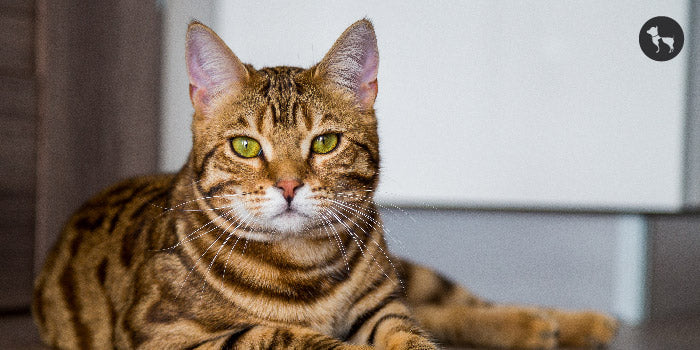

In [63]:
audio_file_path = '/content/drive/My Drive/audio_dataset/audio_dataset/Cat/cat_1.wav'
predict_and_show_image(audio_file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Label: Laughing_Baby


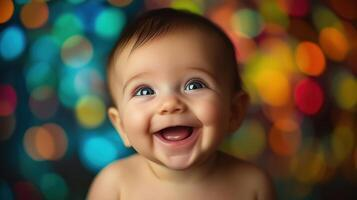

In [64]:
audio_file_path = '/content/drive/My Drive/audio_dataset/audio_dataset/Laughing_Baby/laugh_1.m4a_0.wav'
predict_and_show_image(audio_file_path)
